In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("data/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [8]:
print(f"Train -> {X} \n Test -> {y}")

Train ->        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_inco

In [9]:
X['total_bedrooms'].fillna(X['total_bedrooms'].median(), inplace=True)
X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)

C:\Users\drewj\AppData\Local\Temp\ipykernel_19164\2702352781.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['total_bedrooms'].fillna(X['total_bedrooms'].median(), inplace=True)


In [10]:
X['rooms_per_household'] = X['total_rooms'] / X['households']
X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

In [13]:
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

In [14]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [15]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1, param_grid={'ridge__alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring='r2')

In [16]:
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

Best Parameters: {'ridge__alpha': 10.0}
Best CV R² Score: 0.6559349193804432


In [17]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [18]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [19]:
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Testing R²: {test_r2:.3f}")

Training RMSE: 67597.89
Testing RMSE: 72662.85
Training R²: 0.658
Testing R²: 0.597


In [20]:
feature_names = X.columns
coefficients = best_model.named_steps['ridge'].coef_
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values('Importance', ascending=False)

In [21]:
sns.set_style("whitegrid")
sns.set_palette("husl")

C:\Users\drewj\AppData\Local\Temp\ipykernel_19164\40072651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance, palette="viridis")


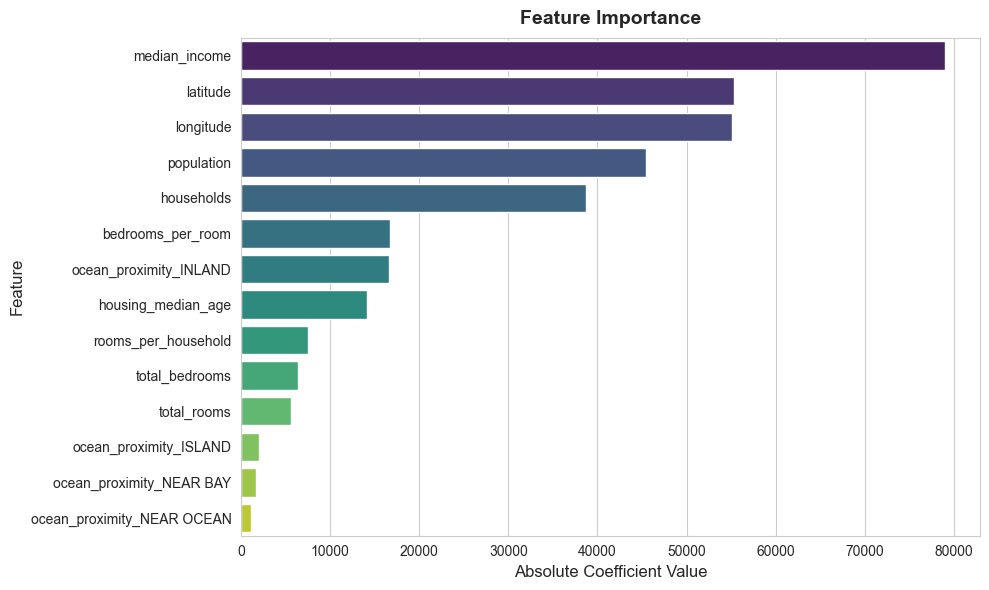

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette="viridis")
plt.title('Feature Importance', fontsize=14, weight='bold', pad=10)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

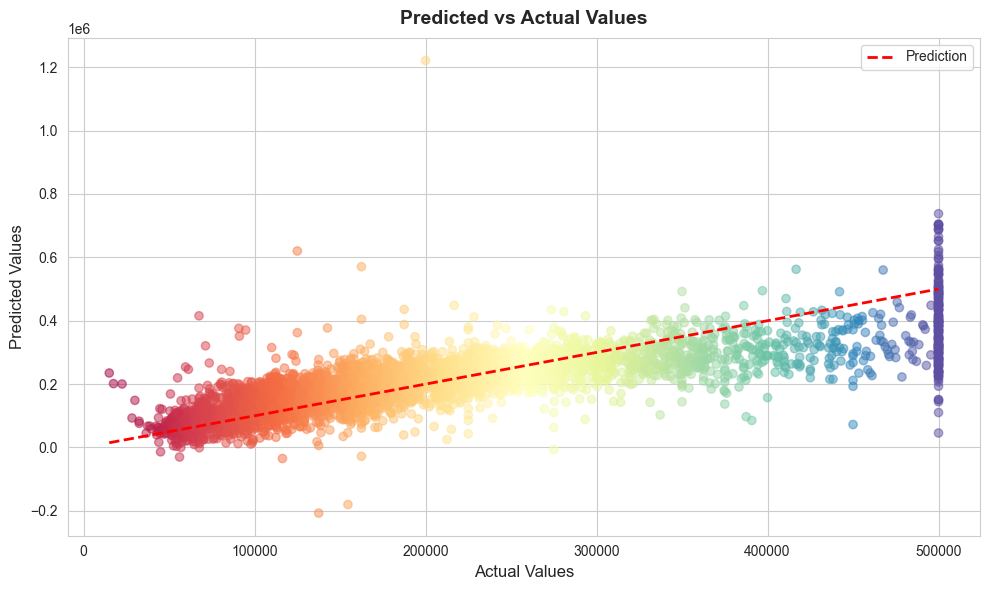

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, cmap='Spectral', c=y_test)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Predicted vs Actual Values', fontsize=14, weight='bold', pad=10)
plt.legend()
plt.tight_layout()
plt.show()